<a href="https://colab.research.google.com/github/indhu-parimi/Deep-Learning-for-Computer-Vision/blob/main/Image_Segmentation_with_U_Net_on_COCO_Dataset_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Initialization



In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO  # API for COCO dataset
import skimage.io as io
import os


In [ ]:
# 1.2 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1.3 Unzip Dataset
!unzip "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/coco2017/"

# Define paths for data
train_data_path = "/content/drive/MyDrive/coco2017/train-300"
val_data_path = "/content/drive/MyDrive/coco2017/val-300"
train_annotation_file = os.path.join(train_data_path, "labels.json")
val_annotation_file = os.path.join(val_data_path, "labels.json")

print("Setup and Initialization Complete")

Mounted at /content/drive
Archive:  /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip
replace /content/drive/MyDrive/coco2017/test-30/000000001751.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001411.jpg  
  in

# Data Loading and Exploration



loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
COCO categories: 
['airplane', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'handbag', 'horse', 'hot dog', 'kite', 'knife', 'laptop', 'motorcycle', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'skateboard', 'skis', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'tennis racket', 'tie', 'traffic light', 'train', 'truck', 'umbrella', 'vase', 'wine glass']

COCO supercategories: 
{'food', 'electronic', 'sports', 'indoor', 'kitchen', 'accessory', 'animal', 'appliance', 'person', 'outdoor', 'furniture', 'vehicle'}

Number of images: 300
Number of annotations: 3870


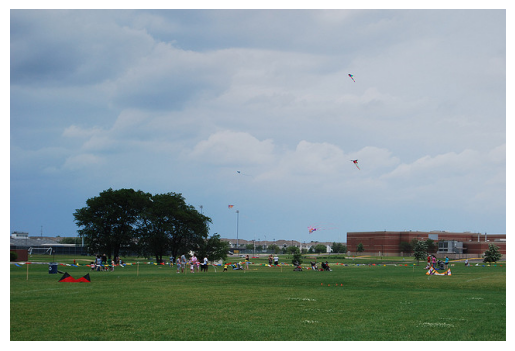

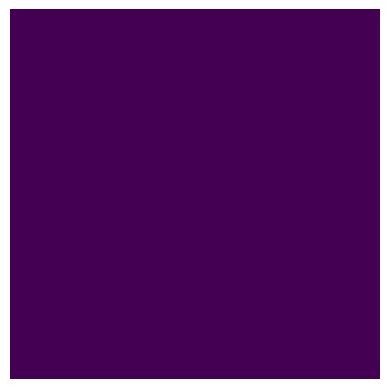

In [ ]:
coco = COCO(train_annotation_file)

# Extract Categories and Supercategories
categories = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in categories]
supercategories = set([cat['supercategory'] for cat in categories])
print(f"COCO categories: \n{nms}\n")
print(f"COCO supercategories: \n{supercategories}\n")

# Retrieve Image and Annotation IDs
image_ids = coco.getImgIds()
annotation_ids = coco.getAnnIds()
print(f"Number of images: {len(image_ids)}")
print(f"Number of annotations: {len(annotation_ids)}")

# Load and Display Sample Images
def display_image_and_annotations(coco, image_id):
    # Load image
    img = coco.loadImgs(image_id)[0]
    image_path = os.path.join(train_data_path, "data", img['file_name'])
    image = io.imread(image_path)

    # Load and display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Load and display annotations
    ann_ids = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    coco.showAnns(anns)

# Display a sample image and its annotations
sample_image_id = image_ids[0]
display_image_and_annotations(coco, sample_image_id)

# Create Segmentation Masks
def create_segmentation_mask(coco, image_id, target_classes):
    img = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img['height'], img['width']))

    for ann in anns:
        class_name = coco.loadCats(ann['category_id'])[0]['name']
        if class_name in target_classes:
            class_index = target_classes.index(class_name) + 1
            mask = np.maximum(mask, coco.annToMask(ann) * class_index)

    return mask

# Define target classes
target_classes = ['cake', 'car', 'dog', 'person']

# Create and display a segmentation mask for the sample image
sample_mask = create_segmentation_mask(coco, sample_image_id, target_classes)
plt.imshow(sample_mask)
plt.axis('off')
plt.show()


#Exploratory Data Analysis (EDA)


Number of images: 300
Number of annotations: 3870
Target class distribution: {'cake': 13, 'car': 1061, 'dog': 14, 'person': 1350}


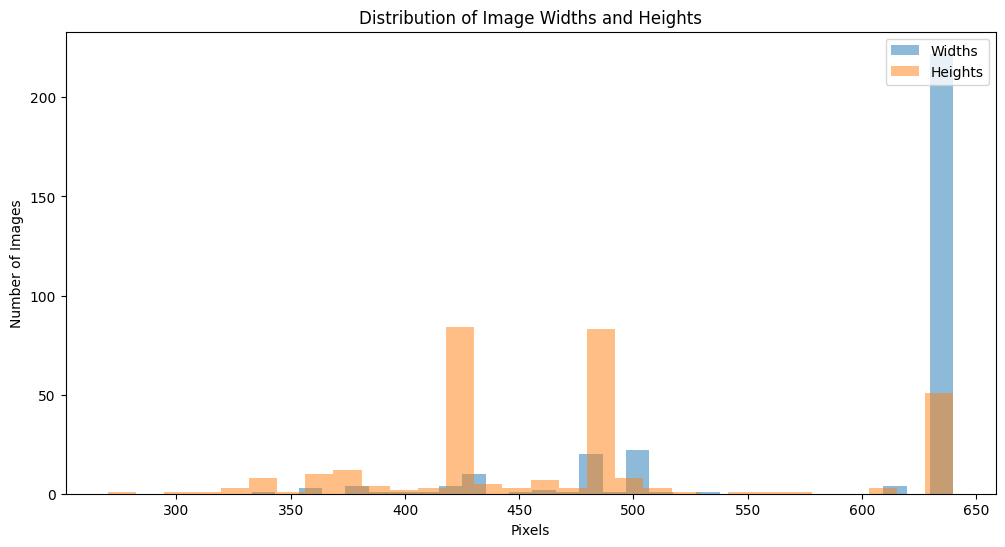

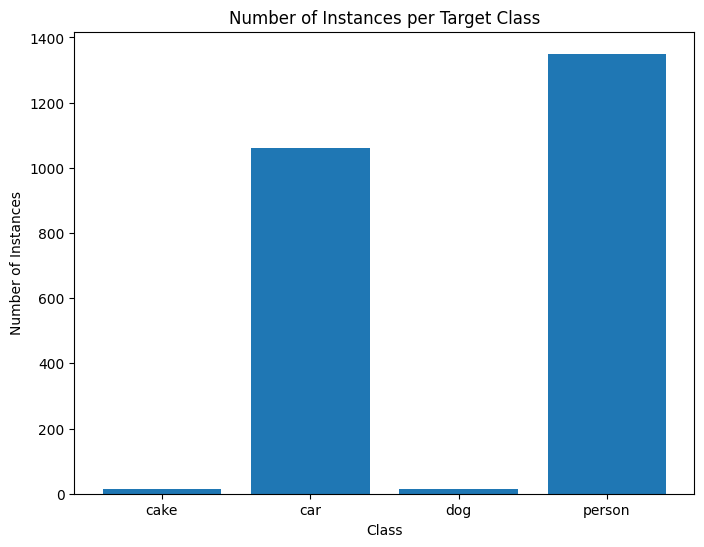

In [ ]:

# Basic Dataset Statistics
def dataset_statistics(coco):
    image_ids = coco.getImgIds()
    annotation_ids = coco.getAnnIds()
    print(f"Number of images: {len(image_ids)}")
    print(f"Number of annotations: {len(annotation_ids)}")

    # Count number of instances per category
    category_counts = {}
    for cat in categories:
        category_counts[cat['name']] = len(coco.getAnnIds(catIds=cat['id']))

    return category_counts

# Get dataset statistics
train_category_counts = dataset_statistics(coco)

# Distribution of Target Classes
def target_class_distribution(coco, target_classes):
    distribution = {class_name: 0 for class_name in target_classes}
    for class_name in target_classes:
        cat_ids = coco.getCatIds(catNms=[class_name])
        ann_ids = coco.getAnnIds(catIds=cat_ids)
        distribution[class_name] = len(ann_ids)
    return distribution

# Get distribution for target classes
target_distribution = target_class_distribution(coco, target_classes)
print(f"Target class distribution: {target_distribution}")

# Image Size Analysis
def image_size_analysis(coco):
    image_sizes = []
    for img_id in coco.getImgIds():
        img = coco.loadImgs(img_id)[0]
        image_sizes.append((img['width'], img['height']))
    return image_sizes

# Get image sizes
image_sizes = image_size_analysis(coco)

# Visualize image sizes
widths, heights = zip(*image_sizes)
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=30, alpha=0.5, label='Widths')
plt.hist(heights, bins=30, alpha=0.5, label='Heights')
plt.legend(loc='upper right')
plt.title('Distribution of Image Widths and Heights')
plt.xlabel('Pixels')
plt.ylabel('Number of Images')
plt.show()

# Visualize the number of instances per target class
plt.figure(figsize=(8, 6))
plt.bar(target_distribution.keys(), target_distribution.values())
plt.title('Number of Instances per Target Class')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()


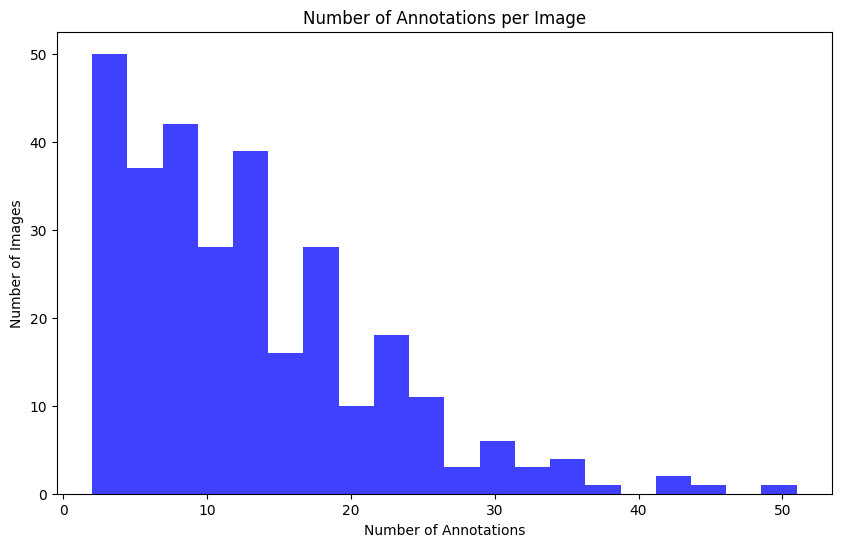

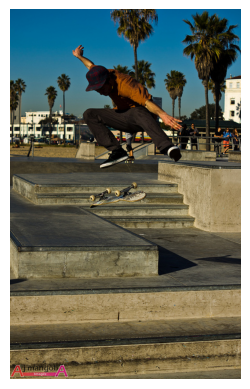

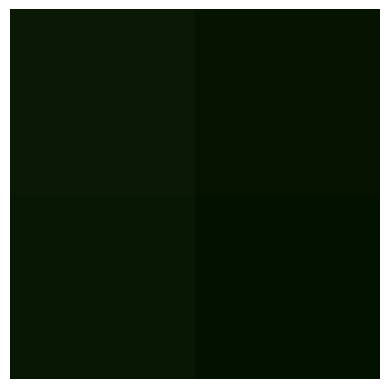

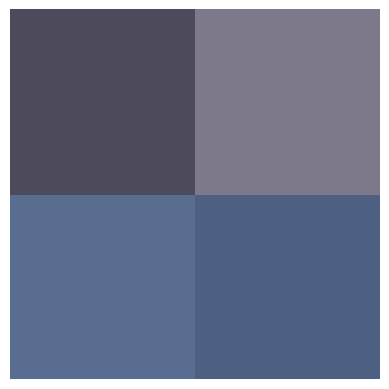

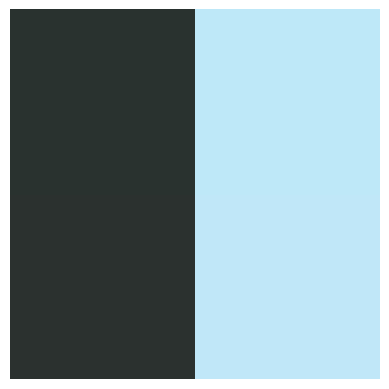

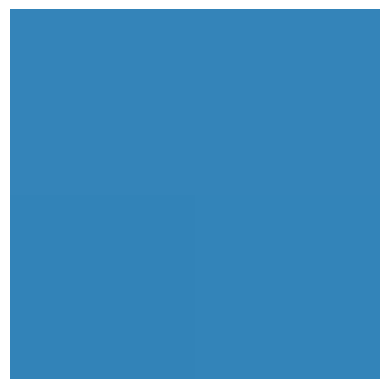

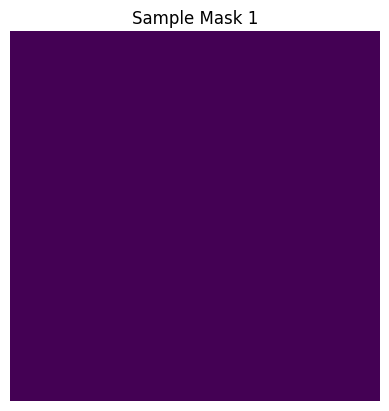

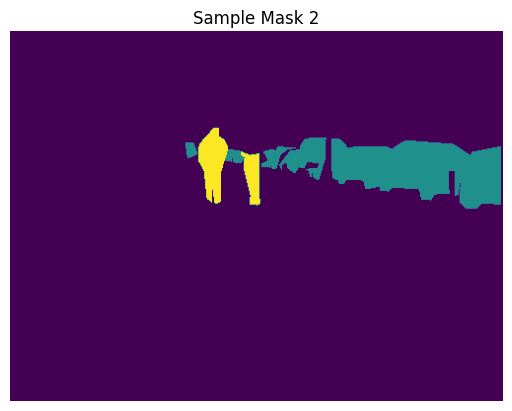

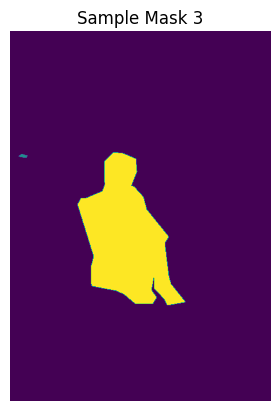

In [ ]:
# 3.4 Annotation Analysis

# Analyze the number of annotations per image
def annotations_per_image_analysis(coco):
    annotations_count = []
    for img_id in coco.getImgIds():
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        annotations_count.append(len(ann_ids))
    return annotations_count

# Get the number of annotations per image
annotations_count = annotations_per_image_analysis(coco)

# Visualize the number of annotations per image
plt.figure(figsize=(10, 6))
plt.hist(annotations_count, bins=20, alpha=0.75, color='blue')
plt.title('Number of Annotations per Image')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Images')
plt.show()

# Function to visualize sample annotations
def visualize_sample_annotations(coco, image_ids, num_samples=5):
    for i in range(num_samples):
        image_id = random.choice(image_ids)
        display_image_and_annotations(coco, image_id)

# Visualize sample annotations
visualize_sample_annotations(coco, image_ids)

# Function to visualize example masks
def visualize_example_masks(coco, image_ids, target_classes, num_samples=3):
    for i in range(num_samples):
        image_id = random.choice(image_ids)
        mask = create_segmentation_mask(coco, image_id, target_classes)
        plt.imshow(mask)
        plt.axis('off')
        plt.title(f'Sample Mask {i+1}')
        plt.show()

# Visualize example masks
visualize_example_masks(coco, image_ids, target_classes)


# Data Preprocessing


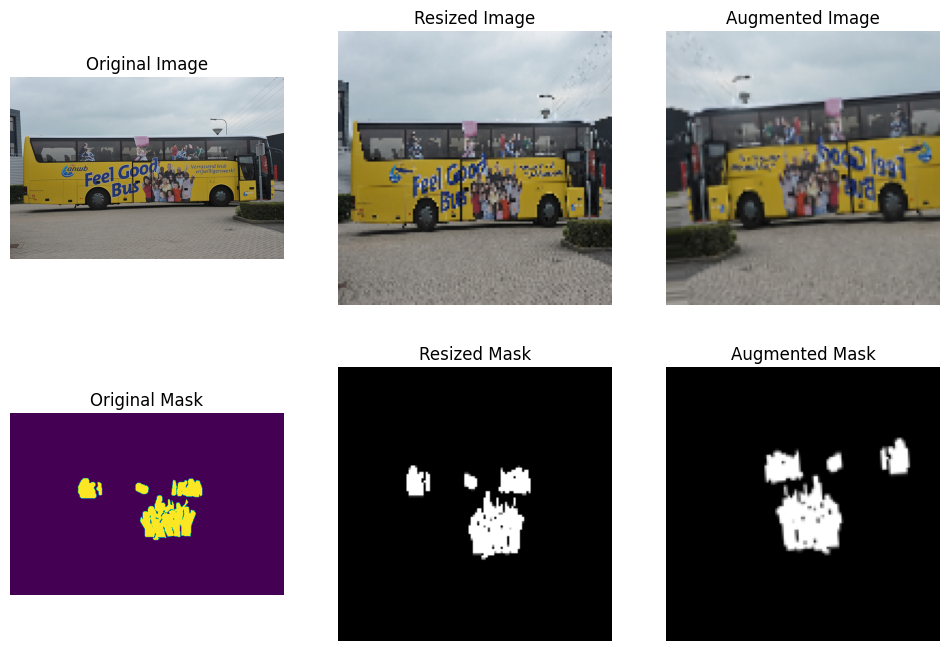

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 4.1 Resize Images
def resize_image(image, target_size=(128, 128)):
    return cv2.resize(image, target_size)

# 4.2 Normalize Images
def normalize_image(image):
    return image / 255.0

# 4.3 Data Augmentation
def augment_image(image, mask, augmentor):
    # Expand dimensions of image and mask for augmentation
    image = np.expand_dims(image, axis=0)
    mask = np.expand_dims(mask, axis=0)

    # Apply augmentation
    augmented = next(augmentor.flow(image, seed=42))
    augmented_mask = next(augmentor.flow(mask, seed=42))

    return augmented[0], augmented_mask[0]

# Create an image data generator for augmentation
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example of preprocessing a single image and mask
image_id = random.choice(image_ids)
image_data = coco.loadImgs(image_id)[0]
image_path = os.path.join(train_data_path, "data", image_data['file_name'])
image = io.imread(image_path)

# Ensure image has 3 color channels
if len(image.shape) == 2:
    image = np.stack([image]*3, axis=-1)
elif image.shape[2] == 4:
    image = image[..., :3]

# Create segmentation mask
mask = create_segmentation_mask(coco, image_id, target_classes)

# Resize image and mask
resized_image = resize_image(image)
resized_mask = resize_image(mask, target_size=(128, 128))

# Normalize image
normalized_image = normalize_image(resized_image)

# Expand mask dimensions to add the channel dimension
resized_mask = np.expand_dims(resized_mask, axis=-1)

# Augment image and mask
augmented_image, augmented_mask = augment_image(normalized_image, resized_mask, image_datagen)

# Visualize the original, resized, and augmented images and masks
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(resized_image)
plt.title("Resized Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(mask)
plt.title("Original Mask")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(resized_mask.squeeze(), cmap='gray')
plt.title("Resized Mask")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(augmented_mask.squeeze(), cmap='gray')
plt.title("Augmented Mask")
plt.axis('off')

plt.show()


# Model Definition


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 5.1 Choose Segmentation Model (U-Net in this case)
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, (2, 2), activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs], outputs=[conv10])

    return model

# 5.2 Define the Model Architecture
model = unet_model()

# 5.3 Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Model Training


Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.8684 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 115s 21s/step - loss: 0.6931 - accuracy: 0.8684 - val_loss: 0.6864 - val_accuracy: 0.8997
Epoch 2/5
5/5 [==============================] - 103s 21s/step - loss: 1.1765 - accuracy: 0.8684 - val_loss: 0.6653 - val_accuracy: 0.8997
Epoch 3/5
5/5 [==============================] - 100s 20s/step - loss: 0.6876 - accuracy: 0.8684 - val_loss: 0.6914 - val_accuracy: 0.8997
Epoch 4/5
5/5 [==============================] - 104s 21s/step - loss: 0.6865 - accuracy: 0.8684 - val_loss: 0.8077 - val_accuracy: 0.8997
Epoch 5/5
5/5 [==============================] - 107s 22s/step - loss: 0.7521 - accuracy: 0.8684 - val_loss: 0.6876 - val_accuracy: 0.8997


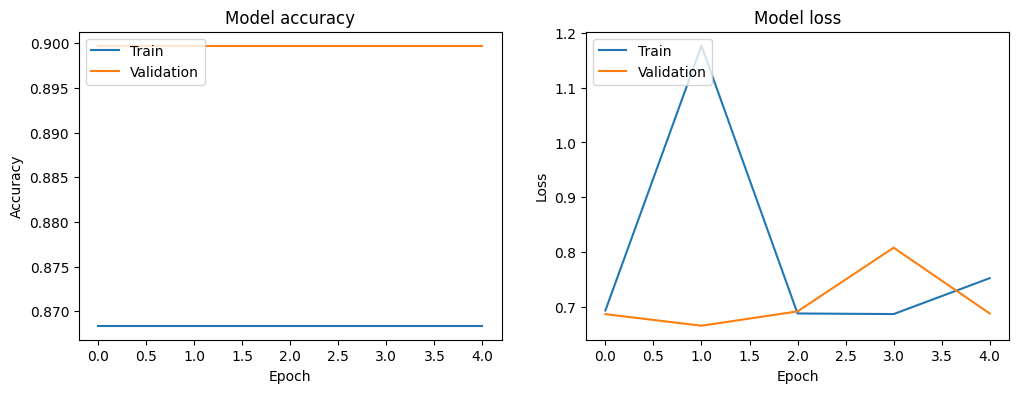

In [ ]:
from sklearn.model_selection import train_test_split

# 6.1 Split Data into Training and Validation Sets
def load_data(coco, image_ids, target_classes, input_size=(128, 128)):
    images = []
    masks = []

    for image_id in image_ids:
        image_data = coco.loadImgs(image_id)[0]
        image_path = os.path.join(train_data_path, "data", image_data['file_name'])
        image = io.imread(image_path)

        # Ensure image has 3 color channels
        if len(image.shape) == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.shape[2] == 4:
            image = image[..., :3]

        # Create segmentation mask
        mask = create_segmentation_mask(coco, image_id, target_classes)

        # Resize and normalize image
        resized_image = resize_image(image, target_size=input_size)
        normalized_image = normalize_image(resized_image)

        # Resize mask and expand dimensions
        resized_mask = resize_image(mask, target_size=input_size)
        resized_mask = np.expand_dims(resized_mask, axis=-1)

        images.append(normalized_image)
        masks.append(resized_mask)

    images = np.array(images)
    masks = np.array(masks)

    return images, masks

# Use a smaller subset of the dataset
subset_image_ids = image_ids[:50]  # Use the first 50 images for quick training
images, masks = load_data(coco, subset_image_ids, target_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# 6.2 Train the Model
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

# Train the model with fewer epochs
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,  # Reduced number of epochs
    batch_size=8,  # Adjust batch size if needed
    callbacks=callbacks
)

# 6.3 Monitor Training Performance
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Model Evaluation


1/1 [==============================] - 6s 6s/step - loss: 0.6653 - accuracy: 0.8997
Validation Loss: 0.6652519106864929
Validation Accuracy: 0.89971923828125
1/1 [==============================] - 1s 850ms/step


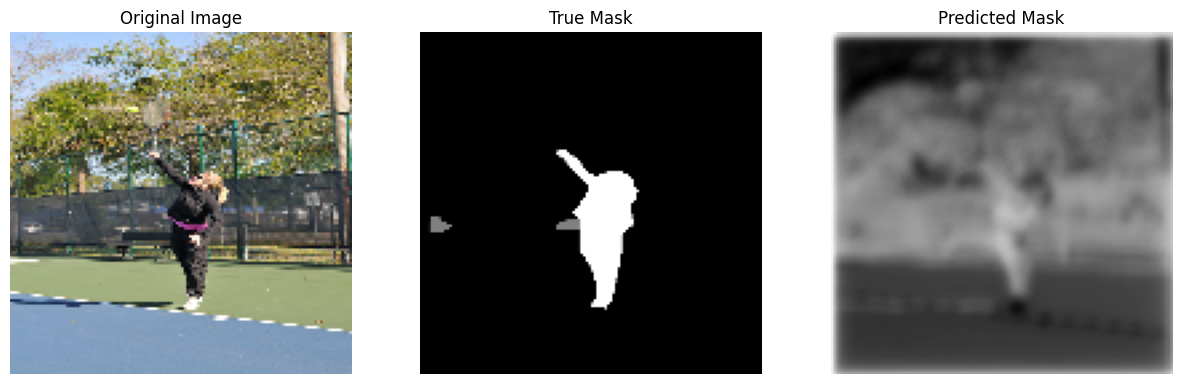

1/1 [==============================] - 1s 560ms/step


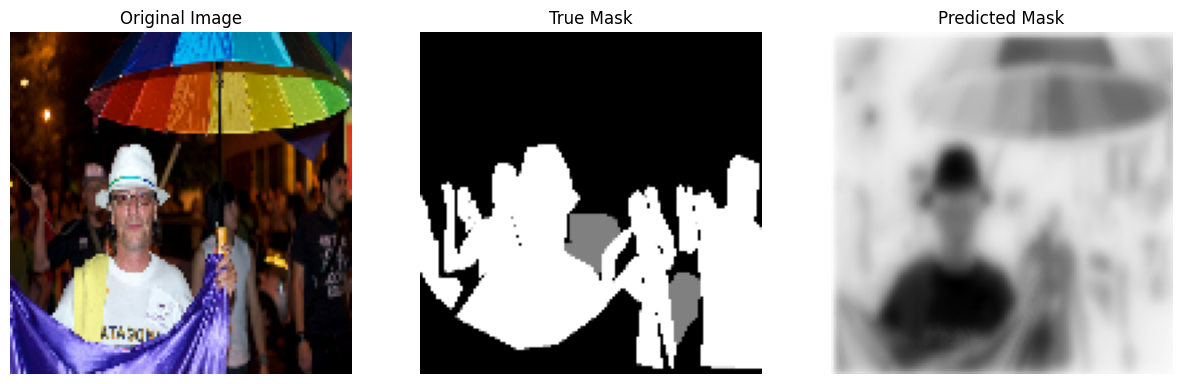

1/1 [==============================] - 1s 562ms/step


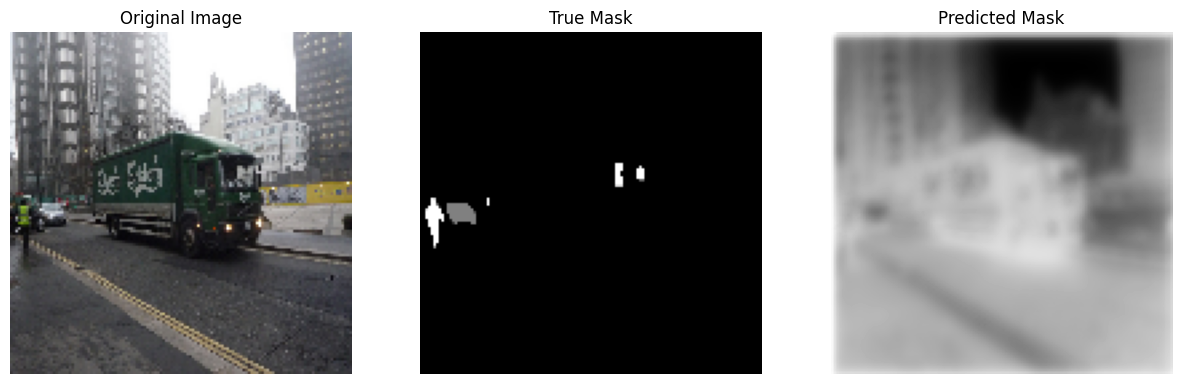

1/1 [==============================] - 1s 535ms/step


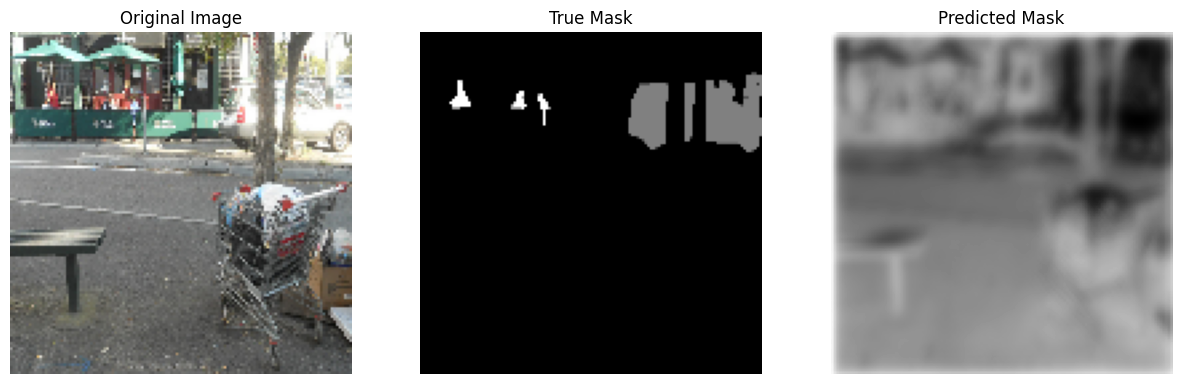

1/1 [==============================] - 1s 535ms/step


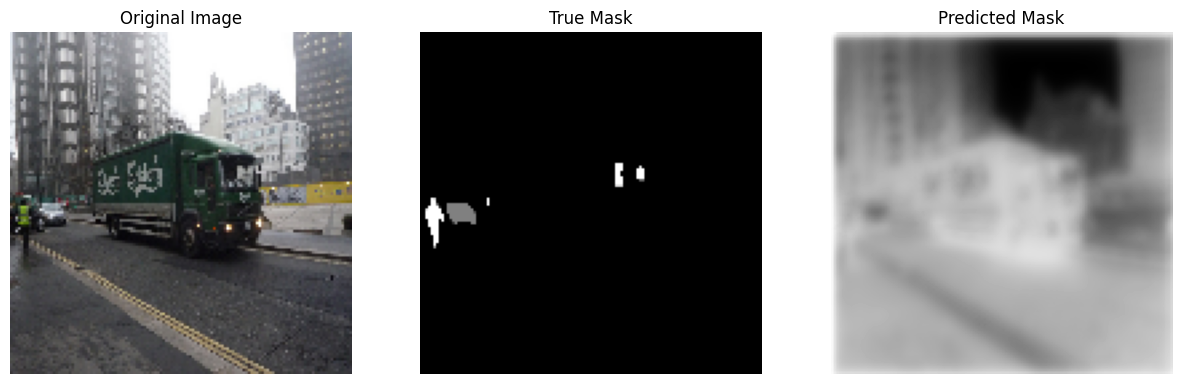

In [ ]:
# Evaluate Model on Validation Set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Visualize Segmentation Results on Validation Set
def visualize_segmentation_results(model, X_val, y_val, num_samples=5):
    for i in range(num_samples):
        idx = random.randint(0, len(X_val) - 1)
        image = X_val[idx]
        true_mask = y_val[idx]

        # Predict the mask
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

        # Plot the original image, true mask, and predicted mask
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

# Visualize segmentation results
visualize_segmentation_results(model, X_val, y_val)


1/1 [==============================] - 1s 749ms/step


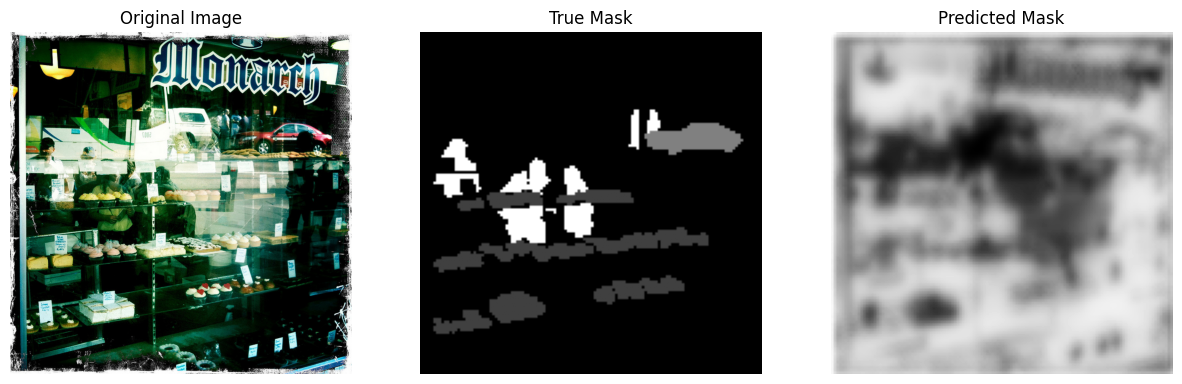

1/1 [==============================] - 1s 974ms/step


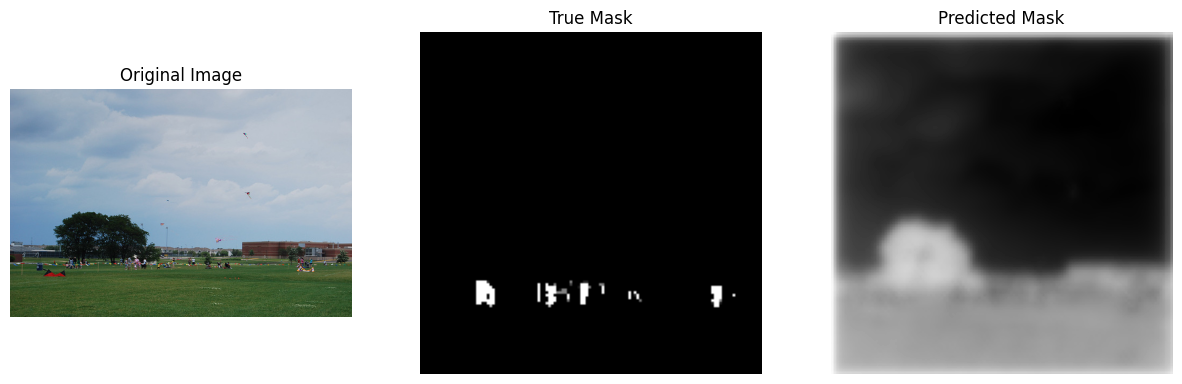

1/1 [==============================] - 1s 975ms/step


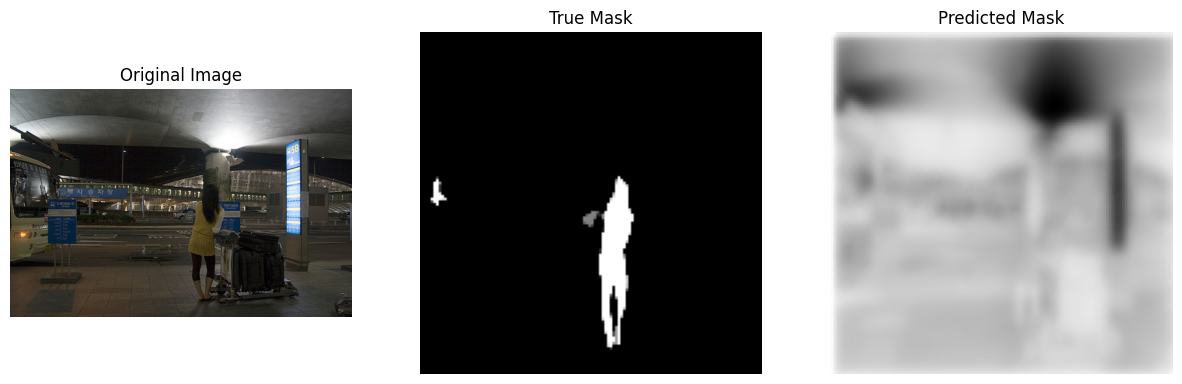

1/1 [==============================] - 1s 501ms/step


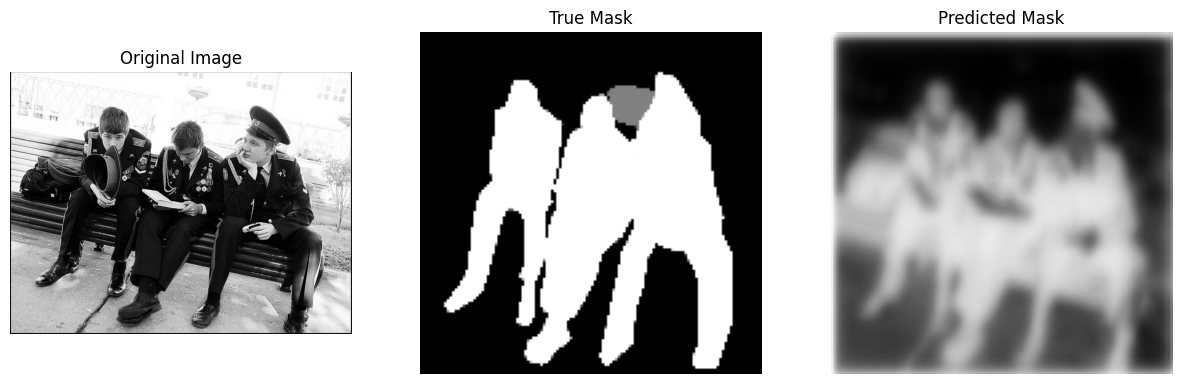

1/1 [==============================] - 1s 513ms/step


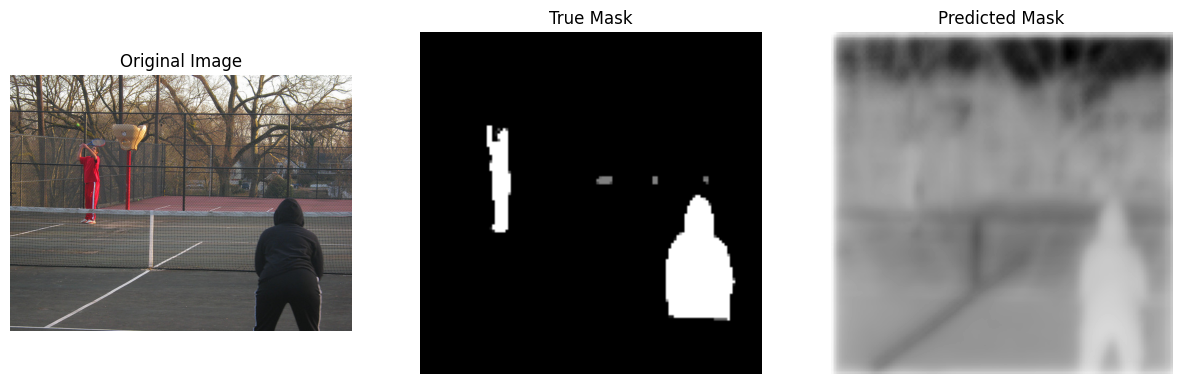

1/1 [==============================] - 1s 528ms/step


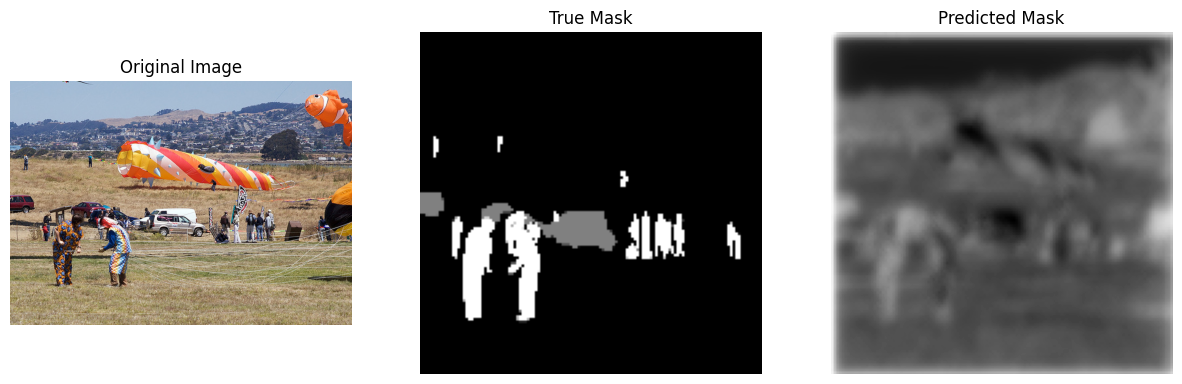

1/1 [==============================] - 1s 544ms/step


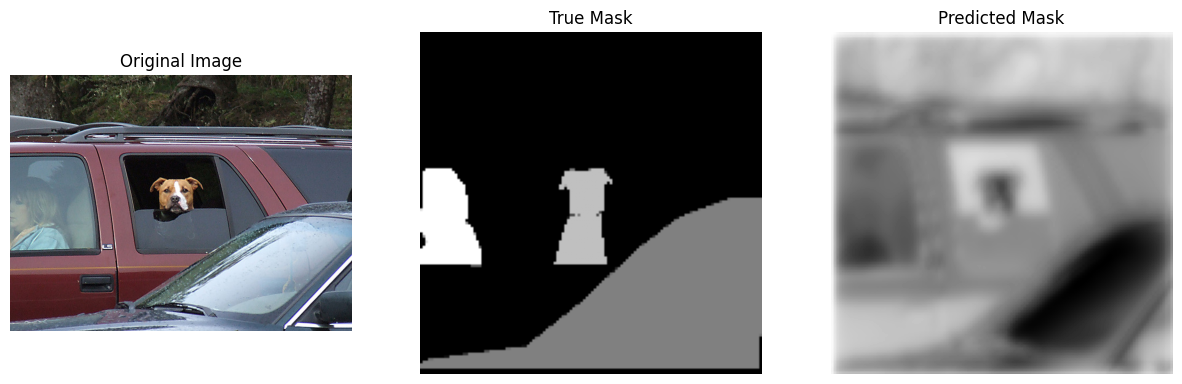

1/1 [==============================] - 1s 1s/step


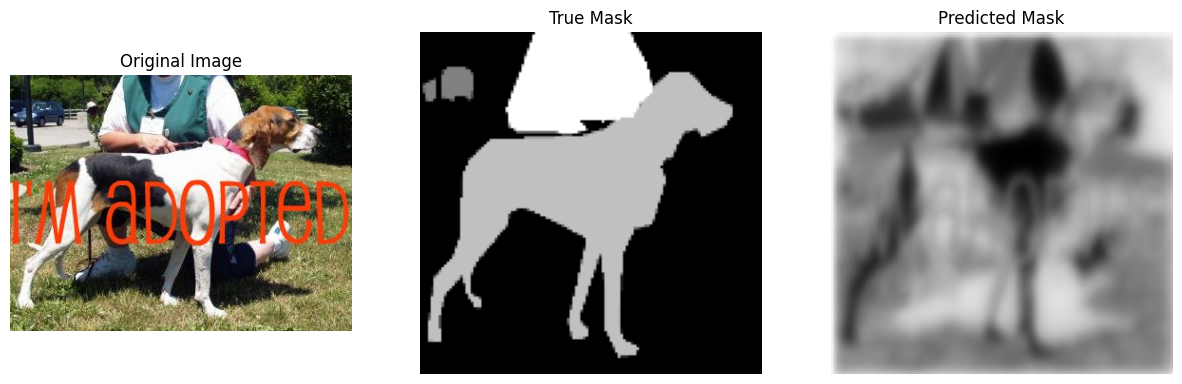

1/1 [==============================] - 1s 749ms/step


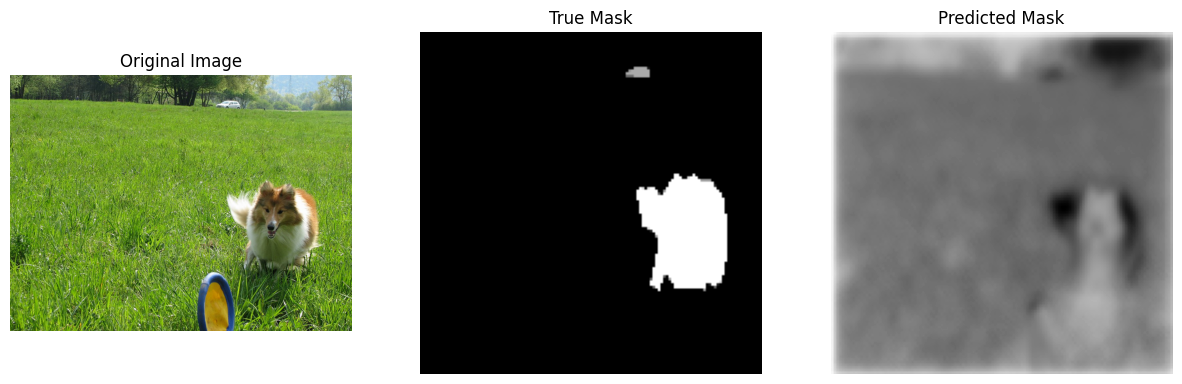

1/1 [==============================] - 1s 1s/step


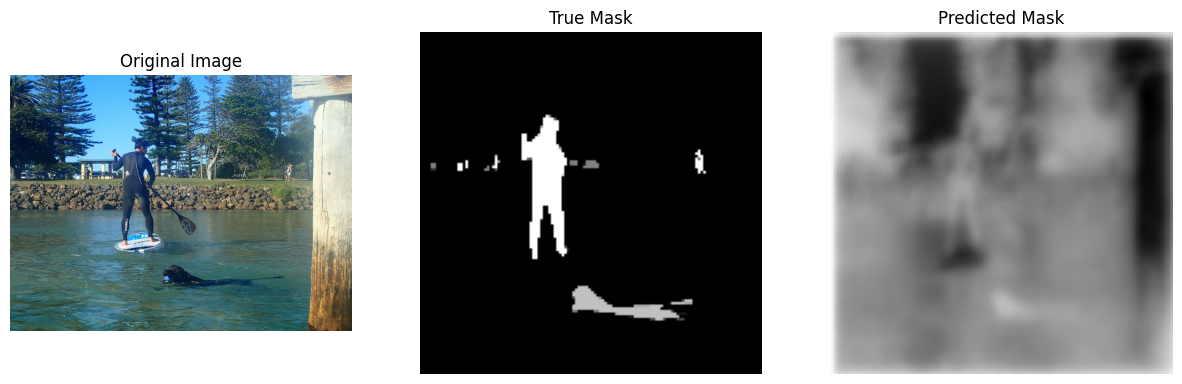

1/1 [==============================] - 2s 2s/step


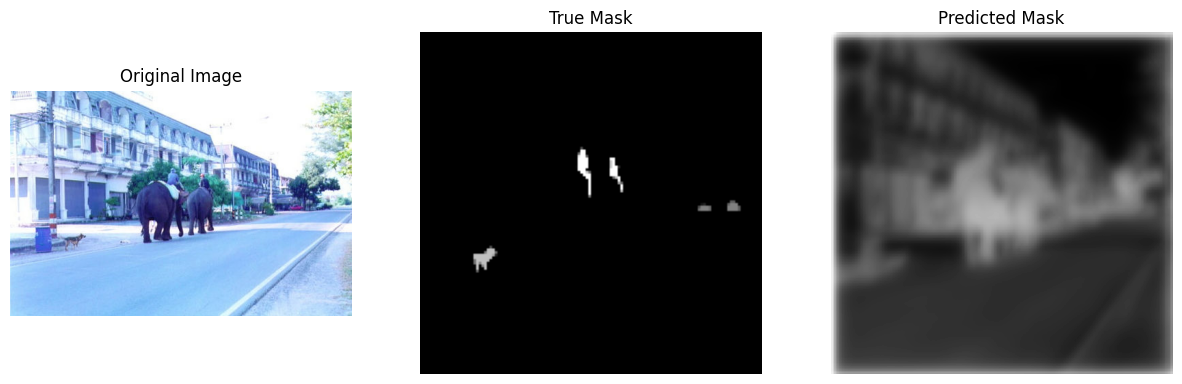

1/1 [==============================] - 1s 1s/step


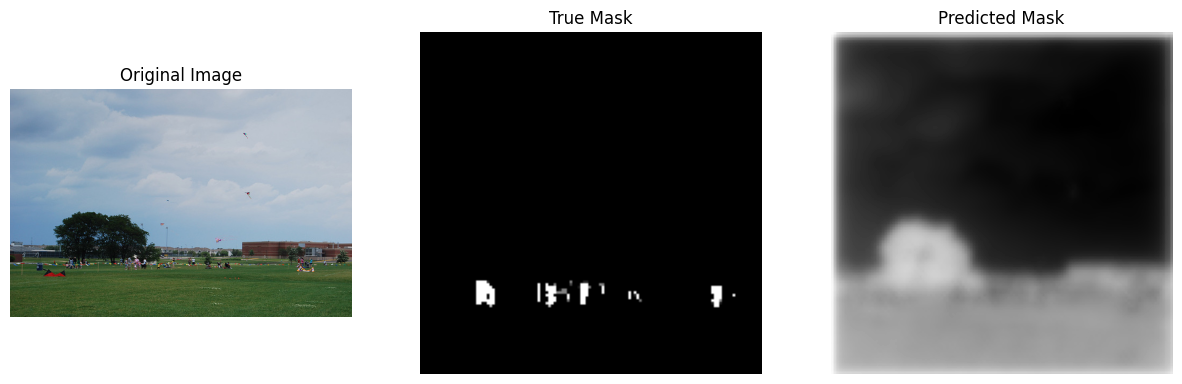

1/1 [==============================] - 1s 526ms/step


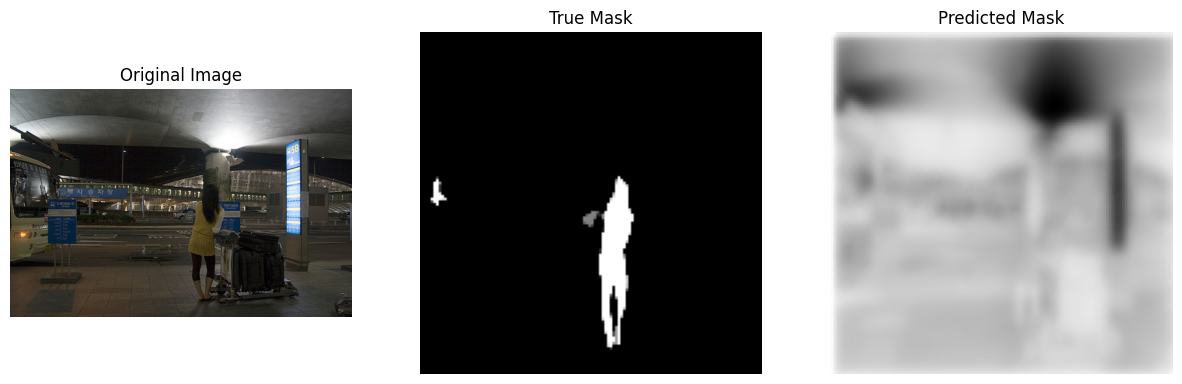

1/1 [==============================] - 1s 522ms/step


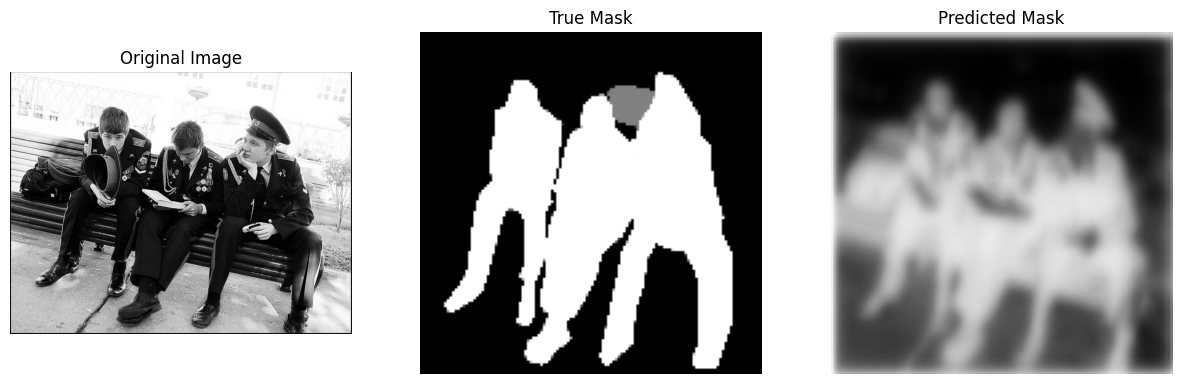

1/1 [==============================] - 1s 557ms/step


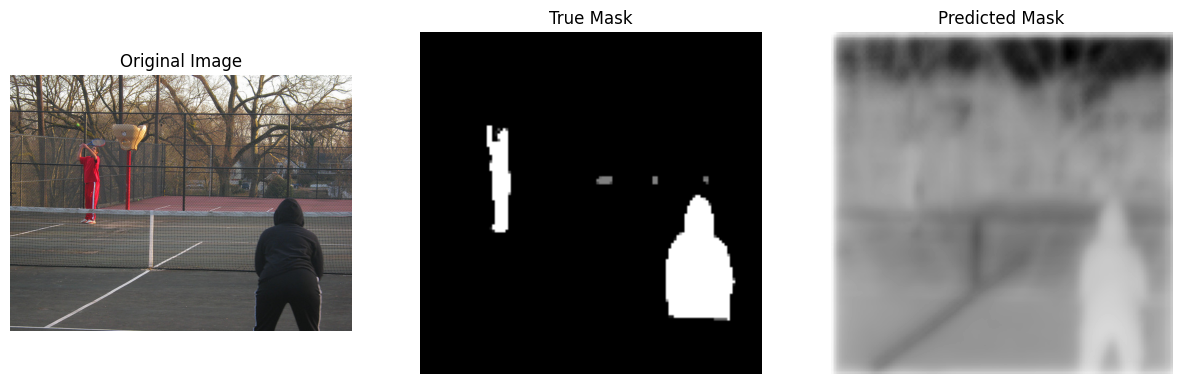

1/1 [==============================] - 1s 549ms/step


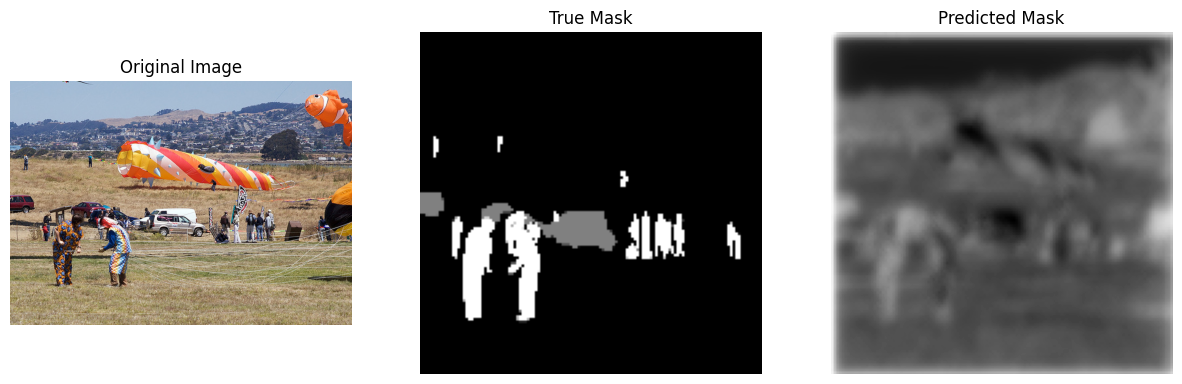

In [ ]:
def visualize_diverse_segmentation_results(model, coco, image_ids, target_classes, num_samples=5):
    # Select a diverse set of images
    selected_images = []
    for class_name in target_classes:
        class_image_ids = coco.getImgIds(catIds=coco.getCatIds(catNms=[class_name]))
        selected_images.extend(class_image_ids[:num_samples])

    # Visualize the results
    for image_id in selected_images:
        image_data = coco.loadImgs(image_id)[0]
        image_path = os.path.join(train_data_path, "data", image_data['file_name'])
        image = io.imread(image_path)

        # Ensure image has 3 color channels
        if len(image.shape) == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.shape[2] == 4:
            image = image[..., :3]

        # Resize and normalize the image
        resized_image = resize_image(image)
        normalized_image = normalize_image(resized_image)

        # Predict the mask
        pred_mask = model.predict(np.expand_dims(normalized_image, axis=0))[0]

        # Create true mask
        true_mask = create_segmentation_mask(coco, image_id, target_classes)
        resized_true_mask = resize_image(true_mask, target_size=(128, 128))
        resized_true_mask = np.expand_dims(resized_true_mask, axis=-1)

        # Plot the original image, true mask, and predicted mask
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(resized_true_mask.squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

# Visualize diverse segmentation results
visualize_diverse_segmentation_results(model, coco, image_ids, target_classes)


# Testing the Model


1/1 [==============================] - 27s 27s/step


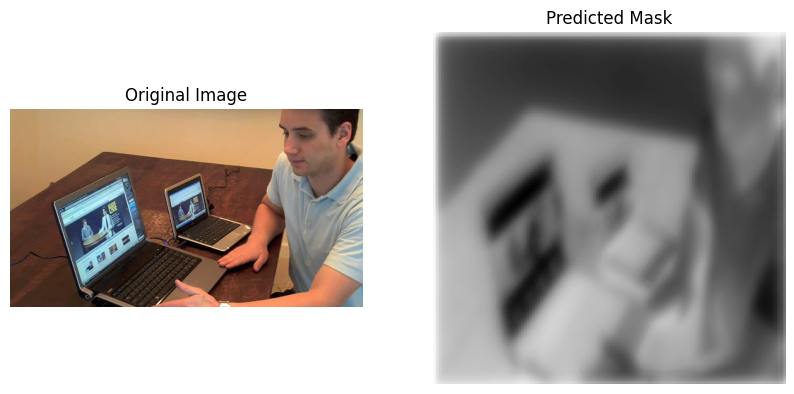

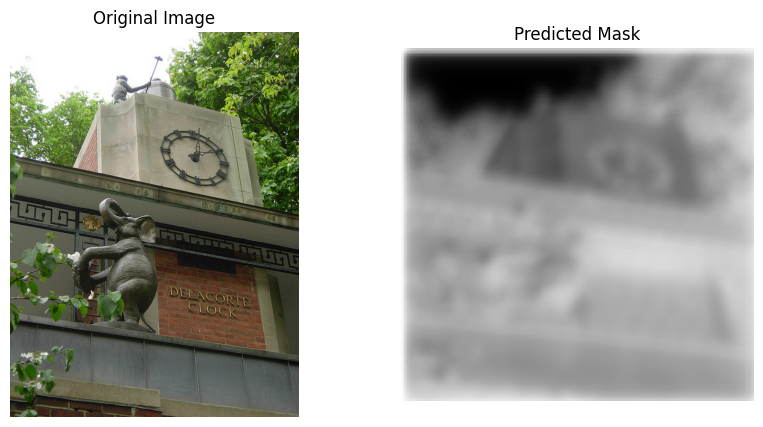

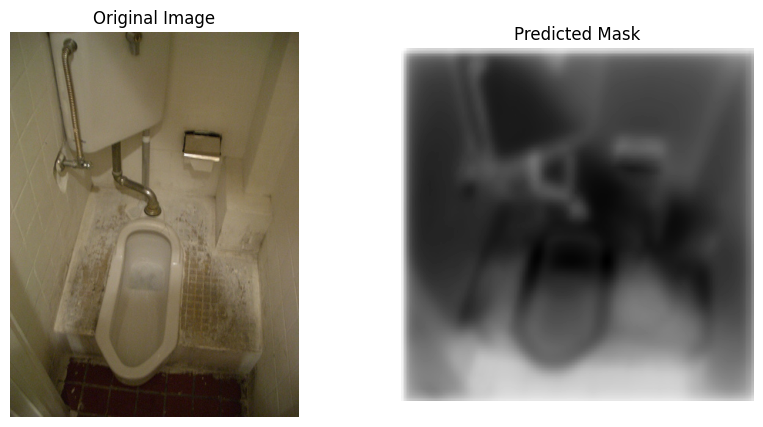

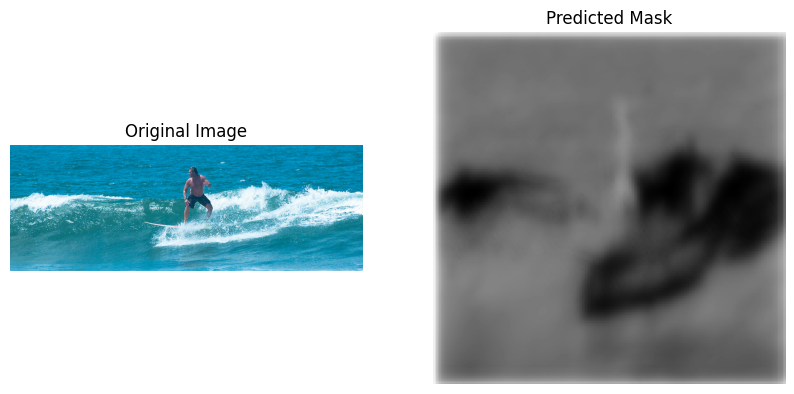

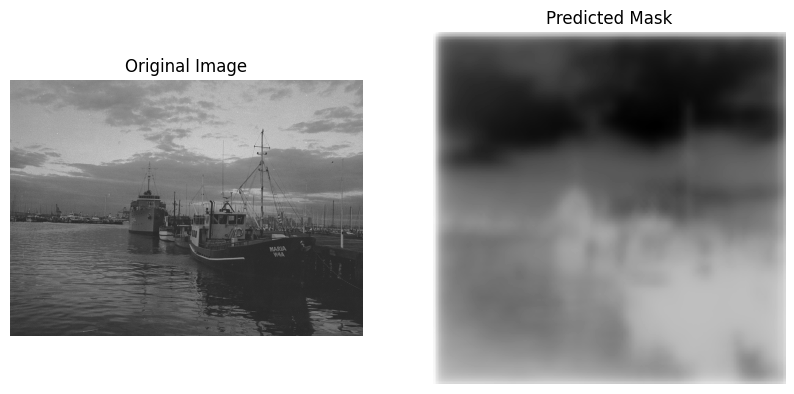

In [ ]:

# Define paths for test data
test_data_path = "/content/drive/MyDrive/coco2017/test-30"

# Get test image filenames
test_image_filenames = os.listdir(test_data_path)

# Load and preprocess test images
def load_test_images(image_filenames, input_size=(128, 128)):
    images = []
    original_images = []

    for filename in image_filenames:
        image_path = os.path.join(test_data_path, filename)
        image = io.imread(image_path)

        # Ensure image has 3 color channels
        if len(image.shape) == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.shape[2] == 4:
            image = image[..., :3]

        # Resize and normalize image
        resized_image = resize_image(image, target_size=input_size)
        normalized_image = normalize_image(resized_image)

        images.append(normalized_image)
        original_images.append(image)

    images = np.array(images)
    return images, original_images

# Load test images
test_images, original_test_images = load_test_images(test_image_filenames)

# Predict masks for test images
predicted_masks = model.predict(test_images)

# Visualize test results
def visualize_test_results(original_images, predicted_masks, num_samples=5):
    for i in range(num_samples):
        idx = random.randint(0, len(original_images) - 1)
        original_image = original_images[idx]
        predicted_mask = predicted_masks[idx]

        # Plot the original image and predicted mask
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

# Visualize test results
visualize_test_results(original_test_images, predicted_masks)


# Save the Trained Model


In [ ]:
model.save('segmentation_model.h5')
print("Model saved as segmentation_model.h5")

Model saved as segmentation_model.h5
